In [ ]:
#Quandl/Nasdaq data

In [2]:
import quandl
quandl.ApiConfig.api_key = 'xi-S9FVvB87vbdfpnfHZ'

In [3]:
import numpy as np
import pandas as pd
#pd.core.common.is_list_like = pd.apo.types.is_list_like
import pandas_datareader.data as web
%matplotlib inline

def get_symbols(symbols, data_source, begin_date=None, end_date=None):
    out = pd.DataFrame()
    for symbol in symbols:
        df=web.DataReader(symbol, data_source, begin_date, end_date, api_key=quandl.ApiConfig.api_key)\
        [['AdjOpen','AdjHigh','AdjLow', 'AdjClose', 'AdjVolume']].reset_index()
        df.columns=['date','open','high','low','close','volume']
        df['symbol'] =symbol
        df=df.set_index(['date','symbol'])
        out=pd.concat([out,df],axis=0)
    return out.sort_index()

prices = get_symbols(['AAPL', 'MSFT'],data_source='quandl', begin_date='2015-01-01',\
                    end_date = '2017-01-01')

In [4]:
prices.head(20)

open        high         low       close      volume
date       symbol                                                            
2015-01-02 AAPL    105.820966  105.868466  101.982949  103.863957  53204626.0
           MSFT     43.251617   43.956101   43.140383   43.344312  27913852.0
2015-01-05 AAPL    102.875953  103.217954  100.139941  100.937944  64285491.0
           MSFT     42.982801   43.316504   42.871566   42.941088  39673865.0
2015-01-06 AAPL    101.213446  102.058949   99.398938  100.947444  65797116.0
           MSFT     42.992070   43.334116   42.213430   42.315395  36447854.0
2015-01-07 AAPL    101.840448  102.790453  101.360696  102.362951  40105934.0
           MSFT     42.621289   43.066226   42.167082   42.853027  29114061.0
2015-01-08 AAPL    103.768957  106.542969  103.265455  106.295968  59364547.0
           MSFT     43.335043   44.261903   43.307234   44.113683  29645202.0
2015-01-09 AAPL    107.036971  107.587974  104.699961  106.409968  53315099.0
           MSFT     44.132222   44.326882   43.474086   43.742902  23715642.0
2015-01-12 AAPL    106.970471  106.998971  103.360455  103.787957  49650790.0
           MSFT     43.956101   44.067335   42.973531   43.196000  23651887.0
2015-01-13 AAPL    105.858966  107.160472  103.464955  104.709461  67091928.0
           MSFT     43.538972   44.410308   42.695445   42.968896  35270601.0
2015-01-14 AAPL    103.588456  104.965962  103.075454  104.310459  48956588.0
           MSFT     42.602750   42.862297   42.287586   42.598115  29719580.0
2015-01-15 AAPL    104.500460  104.557460  101.327446  101.479447  60013996.0
           MSFT     42.843758   42.992070   42.092926   42.157813  32750779.0

In [5]:
features = pd.DataFrame(index=prices.index).sort_index()
features['f01'] = prices.close/prices.open -1 #daily return
features['f02'] = prices.open/prices.groupby(level='symbol').close.shift(1)-1
#to test how prices.groupby(level='symbol').close.shift(1) works, I created this:
# features['f03'] = prices.open/prices.close.shift(1)-1 to see the difference
# the "groupby" is critically import since it it were omitted we would comparing the difference in volume btw symbols

In [6]:
features

f01       f02
date       symbol                    
2015-01-02 AAPL   -0.018494       NaN
           MSFT    0.002143       NaN
2015-01-05 AAPL   -0.018838 -0.009512
           MSFT   -0.000970 -0.008340
2015-01-06 AAPL   -0.002628  0.002729
...                     ...       ...
2016-12-28 MSFT   -0.006467  0.001896
2016-12-29 AAPL    0.002404 -0.002655
           MSFT    0.000636 -0.002064
2016-12-30 AAPL   -0.007115 -0.000685
           MSFT   -0.013024  0.000954

[1008 rows x 2 columns]

In [7]:
#     Differencing
# volume change since prior day
features['f03'] = prices.groupby(level='symbol').volume.diff()
# volume change since 50 days prior
features['f04'] = prices.groupby(level='symbol').volume.diff(50)

In [8]:
#     rate of change

features['f05'] = prices.groupby(level='symbol').volume.pct_change()
pct_change_fxn = lambda x: x.pct_change()
features['f05_a'] = prices.groupby(level='symbol').volume.apply(pct_change_fxn)

#I did a test here to test the differece btw built_in function pct_change and lambda wrapper
#features['f05_b'] = features['f05_a'] -features['f05'] 
#features['f05_b'].sum(). it is 0.0, meaning no differnce at this case

In [9]:
#.      Moving Averages
# CZ: we need to use groupby as the dataframe has multiple symbols(or CFO multiple asset classes) and use lambda
# wrapper to avoid potential error(

# log of 5day Moving average of volume
ma_5=lambda x: x.rolling(5).mean()
features['f06'] = prices.groupby(level='symbol').volume.apply(ma_5).apply(np.log)

## daily volume vs. 200 day moving average
ma_200= lambda x:x.rolling(200).mean()
features['f07'] = prices.volume/prices.groupby(level='symbol').volume.apply(ma_200)-1

# daily closing price vs. 50 day exponential moving avg
ema_50= lambda x: x.ewm(span=50).mean()
features['f08'] = prices.close/prices.groupby(level='symbol').close.apply(ema_50)-1



<AxesSubplot:title={'center':'Z-Scores (not quite accurate)'}, ylabel='Density'>

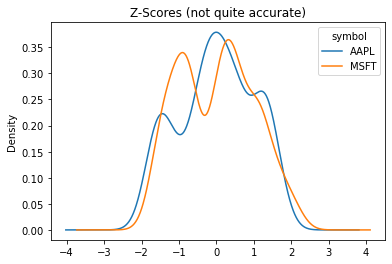

In [10]:
#.        Z-score
#  
zscore_fxn = lambda x:(x-x.mean())/x.std()
features['f09'] = prices.groupby(level='symbol').close.apply(zscore_fxn)
features.f09.unstack().plot.kde(title='Z-Scores (not quite accurate)')

#However, the above example has a subtle but important bug. It uses the mean of the whole time frame and the standard 
#deviation of the whole time frame to calculate each datapoint. This means we are peeking ahead into the future and 
#the feature is potentially very danger-prone (it'll work famously well in sample and fail to work out of sample...).

<AxesSubplot:title={'center':'Z-Scores (improved)'}, ylabel='Density'>

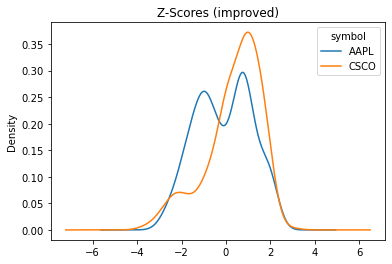

In [57]:
#to fix the issue of peeking into the future by applying the mean and std of all the time frame to each data point
zscore_improved = lambda x: (x-x.rolling(window =200, min_periods=20).mean())/x.rolling(window =200, min_periods=20).std()
features['f10'] = prices.groupby(level='symbol').close.apply(zscore_improved)
features.f10.unstack().plot.kde(title='Z-Scores (improved)')

In [11]:
#      Percentile

rollrank_fxn = lambda x: x.rolling(window=200, min_periods=20) \
.apply(lambda x:pd.Series(x).rank(pct=True)[0])
features['f11']=prices.groupby(level='symbol').volume.apply(rollrank_fxn)


In [12]:


features['f12']=features['f07'].dropna().groupby(level='date').rank(pct=True)

In [13]:

features.head()

f01       f02         f03  f04       f05     f05_a  \
date       symbol                                                            
2015-01-02 AAPL   -0.018494       NaN         NaN  NaN       NaN       NaN   
           MSFT    0.002143       NaN         NaN  NaN       NaN       NaN   
2015-01-05 AAPL   -0.018838 -0.009512  11080865.0  NaN  0.208269  0.208269   
           MSFT   -0.000970 -0.008340  11760013.0  NaN  0.421297  0.421297   
2015-01-06 AAPL   -0.002628  0.002729   1511625.0  NaN  0.023514  0.023514   

                   f06  f07       f08       f09  f11  f12  
date       symbol                                          
2015-01-02 AAPL    NaN  NaN  0.000000 -0.487364  NaN  NaN  
           MSFT    NaN  NaN  0.000000 -0.838856  NaN  NaN  
2015-01-05 AAPL    NaN  NaN -0.014005 -0.783944  NaN  NaN  
           MSFT    NaN  NaN -0.004580 -0.902614  NaN  NaN  
2015-01-06 AAPL    NaN  NaN -0.009132 -0.782981  NaN  NaN

In [14]:
#.      bin
n_bins = 10
bin_fxn= lambda x: pd.qcut(x, q=n_bins,labels=range(1, n_bins+1))
features['f15'] =prices.groupby(level='symbol').volume.apply(bin_fxn)
features['f15_a'] =prices.volume.groupby(level='symbol').apply(bin_fxn)

In [15]:
#       sign
features['f16']=features['f05'].apply(np.sign)

In [16]:
#      plus-minus
plus_minus_fnx = lambda x: x.rolling(20).sum()
features['f17']=features['f16'].groupby(level='symbol').apply(plus_minus_fnx)

In [17]:


# ordinality

month_of_the_year=prices.index.get_level_values(level='date').month

#pd.get_dummies(): Convert categorical variable into dummy/indicator variables.
one_hot_frame = pd.DataFrame(pd.get_dummies(month_of_the_year))

#Be careful! This is forcing index values without usual pandas alignments!
one_hot_frame.index = prices.index

# create column names 
begin_num = int(features.columns[-1][-2:]) + 1 #first available feature
feat_names = ['f'+str(num) for num in list(range(begin_num,begin_num+12,1))]

# rename columns and merge
one_hot_frame.columns = feat_names
features = features.join(one_hot_frame)
print(features.iloc[:,-12:].tail())


                   f18  f19  f20  f21  f22  f23  f24  f25  f26  f27  f28  f29
date       symbol                                                            
2016-12-28 MSFT      0    0    0    0    0    0    0    0    0    0    0    1
2016-12-29 AAPL      0    0    0    0    0    0    0    0    0    0    0    1
           MSFT      0    0    0    0    0    0    0    0    0    0    0    1
2016-12-30 AAPL      0    0    0    0    0    0    0    0    0    0    0    1
           MSFT      0    0    0    0    0    0    0    0    0    0    0    1


In [18]:
one_hot_frame

f18  f19  f20  f21  f22  f23  f24  f25  f26  f27  f28  f29
date       symbol                                                            
2015-01-02 AAPL      1    0    0    0    0    0    0    0    0    0    0    0
           MSFT      1    0    0    0    0    0    0    0    0    0    0    0
2015-01-05 AAPL      1    0    0    0    0    0    0    0    0    0    0    0
           MSFT      1    0    0    0    0    0    0    0    0    0    0    0
2015-01-06 AAPL      1    0    0    0    0    0    0    0    0    0    0    0
...                ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
2016-12-28 MSFT      0    0    0    0    0    0    0    0    0    0    0    1
2016-12-29 AAPL      0    0    0    0    0    0    0    0    0    0    0    1
           MSFT      0    0    0    0    0    0    0    0    0    0    0    1
2016-12-30 AAPL      0    0    0    0    0    0    0    0    0    0    0    1
           MSFT      0    0    0    0    0    0    0    0    0    0    0    1

[1008 rows x 12 columns]

In [19]:
features.iloc[:,-12:]

f18  f19  f20  f21  f22  f23  f24  f25  f26  f27  f28  f29
date       symbol                                                            
2015-01-02 AAPL      1    0    0    0    0    0    0    0    0    0    0    0
           MSFT      1    0    0    0    0    0    0    0    0    0    0    0
2015-01-05 AAPL      1    0    0    0    0    0    0    0    0    0    0    0
           MSFT      1    0    0    0    0    0    0    0    0    0    0    0
2015-01-06 AAPL      1    0    0    0    0    0    0    0    0    0    0    0
...                ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
2016-12-28 MSFT      0    0    0    0    0    0    0    0    0    0    0    1
2016-12-29 AAPL      0    0    0    0    0    0    0    0    0    0    0    1
           MSFT      0    0    0    0    0    0    0    0    0    0    0    1
2016-12-30 AAPL      0    0    0    0    0    0    0    0    0    0    0    1
           MSFT      0    0    0    0    0    0    0    0    0    0    0    1

[1008 rows x 12 columns]